Beeps per minute : 78.62
Beeps per minute : 80.35
Beeps per minute : 70.88
Beeps per minute : 80.08
Beeps per minute : 69.43
Beeps per minute : 78.26
Beeps per minute : 79.99
Beeps per minute : 71.51
Beeps per minute : 79.93
Beeps per minute : 68.96
Beeps per minute : 78.96


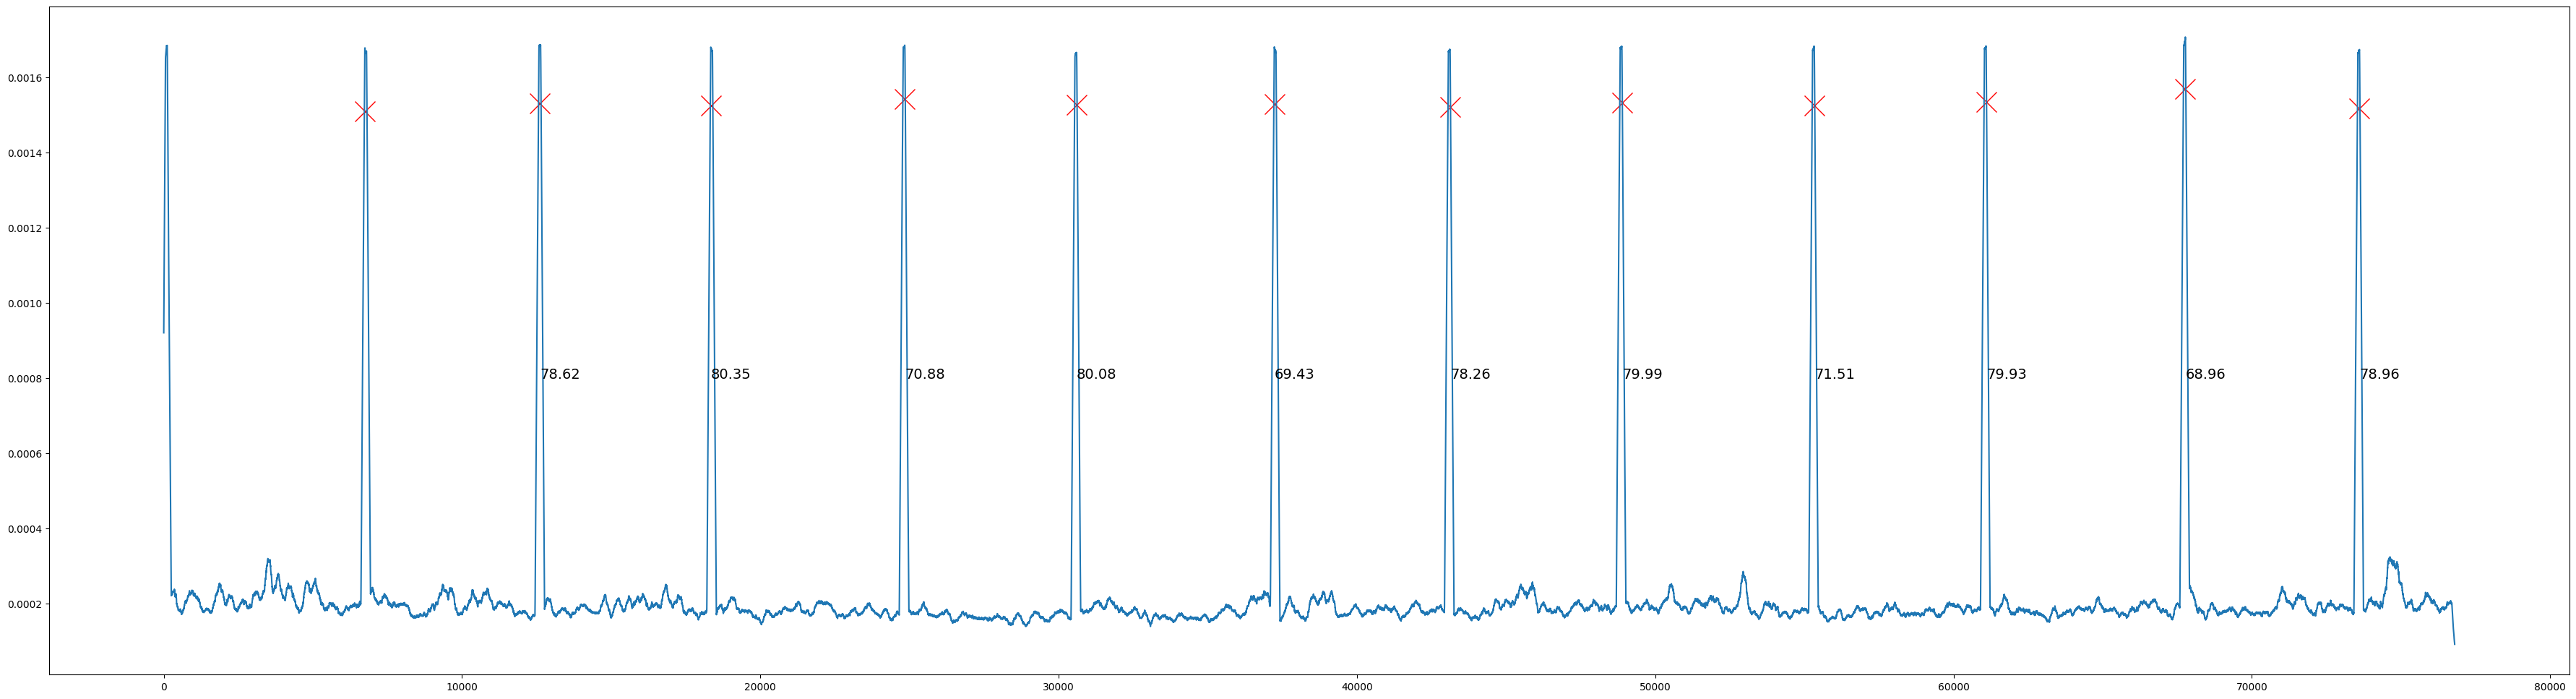

In [19]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
samples = np.fromfile('../data/10s_160377933.fc32', dtype=np.complex64)

sample_rate = 768000
center_freq = 160425000
size = len(samples)
x = samples

t = np.arange(len(x))/912000
h = signal.firwin(501, 0.02, pass_zero=True)
p = np.exp(2j*np.pi*t*47000)

z = x

z = z * p
z = signal.convolve(z, h, 'same')
z = z[::100]
z = np.abs(z)
z = signal.convolve(z, [1]*189, 'same')/189

#z_peaks = signal.find_peaks(z, prominence=0.008)
z_peaks = signal.find_peaks(z, prominence=0.001)

plt.figure(figsize=(45,12))
plt.plot(z_peaks[0], z_peaks[1]["prominences"], marker='x', linestyle='', color="r", markersize=20)

for i in range (0, len(z_peaks[0])-1):
    print(f"Beeps per minute : {round((7680/(z_peaks[0][i+1]-z_peaks[0][i]))*60, 2)}")
    plt.annotate(round((7680/(z_peaks[0][i+1]-z_peaks[0][i]))*60, 2), xy=( z_peaks[0][i+1]+10 , 0.8e-3), size=14)
plt.plot(z)
#plt.title(f"Time Domain 160.339 Mhz @ {int (60 / ((y_peaks[0][3]-y_peaks[0][2]) / 10240))} BPM")
plt.show()

In [1]:
import numpy as np
import pylab as plt
import scipy

def db(x):
    return 10*np.log10(x)

In [2]:
import scipy.signal

#d = np.fromfile(open("test_multiple_v2.fc32"), dtype=np.complex64)
#d = np.fromfile(open("six_channels_768000.fc32"), dtype=np.complex64)
#d = np.fromfile(open("neighbouring_ch_912000_3.fc32"), dtype=np.complex64)
d = np.fromfile(open("../data/10s_160377933.fc32"), dtype=np.complex64)

f0 = 160.425e6    # Center frequency
Fs = 768e3        # Sampling rate
#Fs = 912e3        # Sampling rate
N_fft = 1024      # Number of FFT channels

# Generate array of channel frequencies
f = (np.fft.fftshift(np.fft.fftfreq(N_fft, 1/Fs)) + f0) / 1e6

# Time tag each sample
t = np.arange(len(d)) / Fs

# Reshape so we can do an FFT over an axis
d_fft = d.reshape((-1, N_fft))
D = np.fft.fftshift(np.fft.fft(d_fft, axis=1))

# Time tag each sample coming from a channel
T = np.arange(len(D)) / Fs * N_fft

# Now convert into power spectral density
# 1. Reshape to (N_timestep, N_int_per_timestep, N_fft)
# 2. Square
# 3. Sum over N_int_per_timestep axis
N_time_PSD = 1500
PSD = (np.abs(D.reshape((N_time_PSD, -1, N_fft)))**2).mean(axis=1)

# Create overall spectrum
spec = PSD.mean(axis=0)

# Find peaks (note: I hand-tuned prominence)
p = scipy.signal.find_peaks(spec, prominence=0.05)[0]

In [3]:
# Extract the time series for each channel identified
t_kiwis = []
for idx in p:
    t_kiwis.append(D[:, idx])

# And extract the carrier frequencies
f_kiwis = f[p]

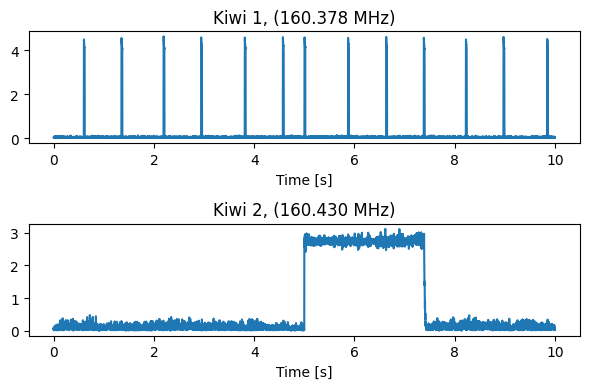

In [5]:
plt.figure(figsize=(6, len(p) * 2))

for ii, tk in enumerate(t_kiwis):
    plt.subplot(len(p), 1, ii+1)
    plt.plot(T, np.abs(tk))
    plt.title(f"Kiwi {ii+1}, ({f_kiwis[ii]:.3f} MHz)")
    plt.xlabel("Time [s]")
    
plt.tight_layout()

In [21]:
threshold = 0.5
for ii, tk in enumerate(t_kiwis):
    low_samples = np.abs(tk) < threshold
    high_samples = np.abs(tk) >= threshold
    rising_edge_idx = np.nonzero(low_samples[:-1] & np.roll(high_samples, -1)[:-1])[0]
    falling_edge_idx = np.nonzero(high_samples[:-1] & np.roll(low_samples, -1)[:-1])[0]
    if ii == 0:
        # work out beeps per minute 
        print(" Beeps per minute")
        print( 60 / (np.diff(rising_edge_idx)/750))



 Beeps per minute
[ 79.92895204  71.42857143  80.07117438  68.91271057  78.94736842
 139.31888545  69.01840491  78.94736842  79.92895204  71.42857143
  80.07117438  68.91271057]
